# CNV detection workshop (G. Demidov)

Hello all to our tutorial about CNV detection. We will discuss how to generate observations (in other words, simulate coverage data) and how to start implementation of Viterbi, Forward algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def isclose(a, b, rel_tol=1e-09, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

In [3]:
class Generator_of_coverage:
    length_of_genome = 10000
    coverage_depth = 30
    copy_number_state = [2 for i in range(0, length_of_genome)]
    coverage_of_genome = []
    
    def __init__(self):
        self.coverage_of_genome = [self.generate_coverage(i)[0] for i in range(0,self.length_of_genome)]
    
    def generate_coverage(self, i):
        return np.random.poisson(self.coverage_depth * self.copy_number_state[i] / 2, 1)
    
    def plot_coverage_hist(self):
        count, bins, ignored = plt.hist(self.coverage_of_genome, 14, density=True)
        
    def plot_coverage(self):
        plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
        plt.scatter(range(0, self.length_of_genome), self.coverage_of_genome)
        plt.ylim(ymin=0)
        
    def print_coverage(self):
        print(self.coverage_of_genome)

In [4]:
new_coverage = Generator_of_coverage()

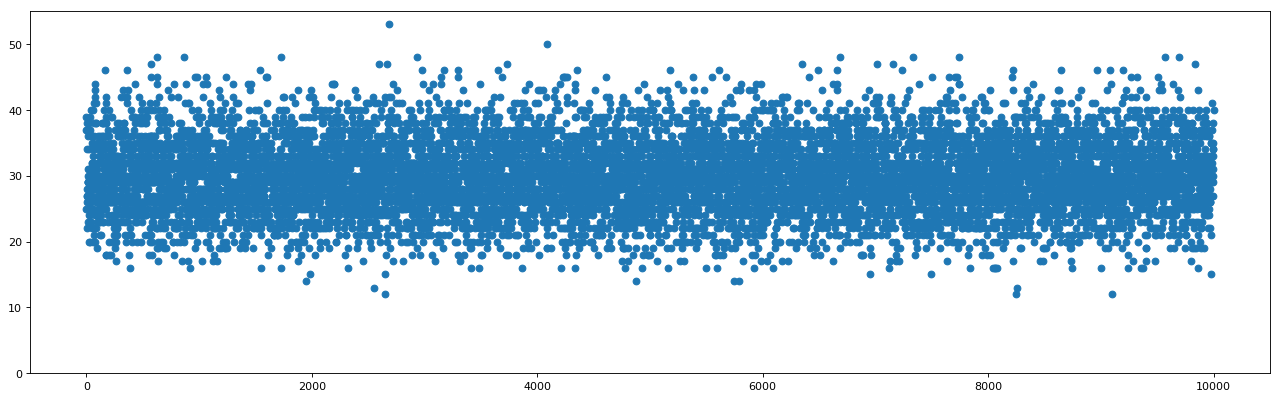

In [5]:
new_coverage.plot_coverage()

Let us make a following exercise - change copy numbers of one part from 200 to 300 from 2 to 3. Try to do the same with other parts of the genome.

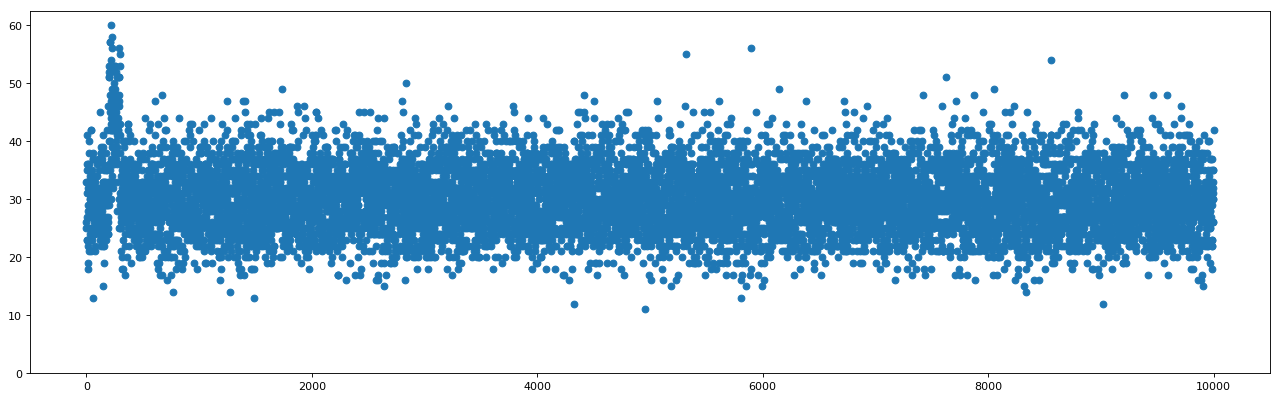

In [6]:
for i in range(200,300):
    new_coverage.copy_number_state[i] = 3
new_coverage = Generator_of_coverage()
new_coverage.plot_coverage()

Now we add 2 more functions to our class: first will generate copy numbers (will contain automaton), second will give a state according to the vector of probabilities of different states, e.g., [0.1,0.5,0.4] - vector of probabilities to choose between options 0,1,2, if we will check 0.55, it will give output 1 as output.

In [7]:
from math import sqrt
from random import randint

In [15]:
class Generator_of_coverage:
    length_of_genome = 10000
    coverage_depth = 30
    copy_number_state = [2 for i in range(0, length_of_genome)]
    coverage_of_genome = []
    gc = [0.4 for i in range(length_of_genome)]
    gc_modifiers = []
    
    def __init__(self):
        self.generate_gc_for_the_genome()
        self.update_gc_modifiers()
        self.generate_coverage()
        
    def generate_coverage(self):
        self.coverage_of_genome = [self.generate_coverage_at_point(i)[0] for i in range(0,self.length_of_genome)]
        return(self.coverage_of_genome)
    
    def generate_coverage_at_point(self, i):
        return np.random.poisson(self.gc_modifiers[i] * self.coverage_depth * self.copy_number_state[i] / 2, 1)
    
    def plot_coverage_hist(self):
        count, bins, ignored = plt.hist(self.coverage_of_genome, 14, density=True)
        
    def plot_coverage(self):
        plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
        plt.scatter(range(0, self.length_of_genome), self.coverage_of_genome)
        plt.ylim(ymin=0)
        
    def print_coverage(self):
        print(self.coverage_of_genome)
    
    def continuous_probability_to_outcome(self, prob_vect, prob):
        assert sum(prob_vect) >= 0.9999999
        assert len(prob_vect) > 0
        borders_of_decision = np.cumsum(prob_vect)
        i = 0
        for i in range(0, len(prob_vect)):
            if prob < borders_of_decision[i]:
                break
        return i
    
    def generate_copy_number_states(self):
        states = (1,2,3)
        state_one_probs_to_switch = (0.99, 0.01, 0)
        state_two_probs_to_switch = (0.0001, 0.9998, 0.0001)
        state_three_probs_to_switch = (0, 0.01, 0.99)
        array_of_transition_probabilites = [state_one_probs_to_switch, state_two_probs_to_switch, state_three_probs_to_switch]
        start_probs = (0.005, 0.99, 0.005)
        current_state = self.continuous_probability_to_outcome(start_probs, np.random.uniform(0,1,1))
        print("Start state")
        print(current_state)
        for j in range(0, self.length_of_genome):
            self.copy_number_state[j] = states[current_state]
            new_current_state = self.continuous_probability_to_outcome(array_of_transition_probabilites[current_state], np.random.uniform(0,1,1))
            if new_current_state != current_state:
                print("Switch of states happened:")
                print(new_current_state, "coord of start:", j)
            current_state = new_current_state
        self.coverage_of_genome = [self.generate_coverage_at_point(i)[0] for i in range(0,self.length_of_genome)]
        
    def estimate_means_and_standard_deviations(self):
        control_cohort = [[self.generate_coverage_at_point(i)[0] for i in range(0,self.length_of_genome)] for j in range(100)]
        means = []
        stddevs = []
        for i in range(len(self.coverage_of_genome)):
            coverage_of_position = []
            for j in range(len(control_cohort)):
                coverage_of_position.append(sqrt(control_cohort[j][i]))
            means.append(np.mean(coverage_of_position))
            stddevs.append(np.std(coverage_of_position))
        with open("population_parameter.txt", "w") as f:
            for i in range(len(self.coverage_of_genome)):
                f.write("\t".join([str(means[i]), str(stddevs[i])]) + "\n")
                
    def generate_gc_for_the_genome(self):
        self.gc = [0.1 * randint(4,5) for i in range(len(self.gc))]
        
    def update_gc_modifiers(self):
        self.gc_modifiers = [self.modify_coverage_according_to_gc(self.gc[i]) for i in range(len(self.gc))]
        
    def modify_coverage_according_to_gc(self, particular_gc):
        if isclose(particular_gc, 0.4):
            return(1.0)
        elif isclose(particular_gc, 0.5):
            return(0.9)
        
        

In [16]:
new_coverage = Generator_of_coverage()



In [17]:
new_coverage.generate_gc_for_the_genome()
new_coverage.update_gc_modifiers()
new_coverage.generate_coverage()
new_coverage.estimate_means_and_standard_deviations()

Start state
1
Switch of states happened:
2 coord of start: 27
Switch of states happened:
1 coord of start: 169
Switch of states happened:
0 coord of start: 876
Switch of states happened:
1 coord of start: 980
Switch of states happened:
2 coord of start: 9706
Switch of states happened:
1 coord of start: 9829
Switch of states happened:
2 coord of start: 12259
Switch of states happened:
1 coord of start: 12319
Switch of states happened:
0 coord of start: 20960
Switch of states happened:
1 coord of start: 20974
Switch of states happened:
0 coord of start: 22057
Switch of states happened:
1 coord of start: 22106
Switch of states happened:
0 coord of start: 22314
Switch of states happened:
1 coord of start: 22335
Switch of states happened:
0 coord of start: 25176
Switch of states happened:
1 coord of start: 25243
Switch of states happened:
2 coord of start: 25446
Switch of states happened:
1 coord of start: 25480
Switch of states happened:
0 coord of start: 30590
Switch of states happened:
1

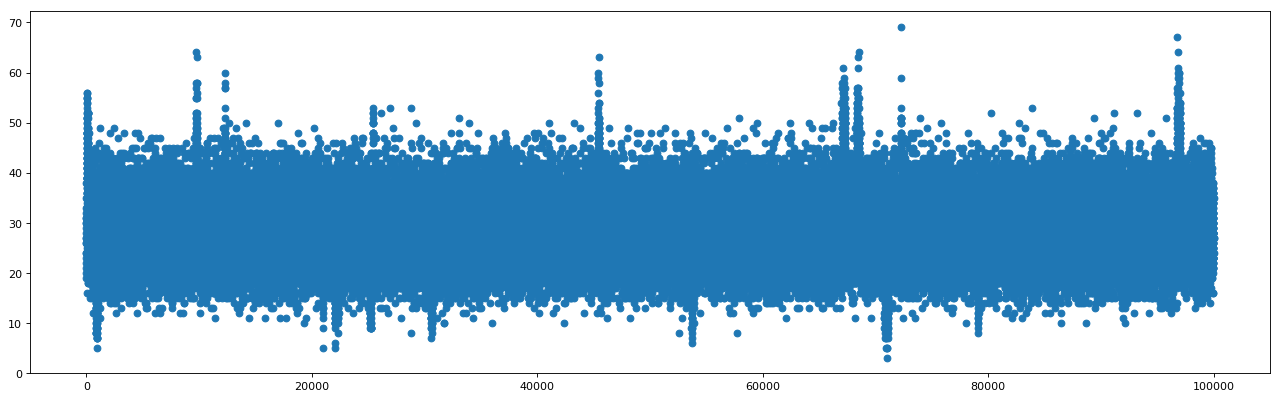

In [18]:
new_coverage.generate_copy_number_states()
new_coverage.plot_coverage()

We can also introduce some biases (such as GC) and make coverage less uniform. It will be your homework - instead of lambda Possion generator has to take f(GC, lambda). GC needs to have maximum at 0.4 and minimum at 0 and 1. It can be any function of your choice with only one local maximum.

Also your homework is to code generator from copy numbers 0 to 3. Poisson can not be applied with lambda 0, what would you do?

What will you need for implementing Viterbi/Forward algorithms is probability to see this observation. 

In [ ]:
# Here read user parameters sample_counts and population_parameters with argparse

class cnv_hmm():
    
    coverage = []
    means = []
    stddev = []
    
    # Here define the Hidden Markov model: 
    # Matirces of start probability, observation probability, transition probability
    # Take values from the generator
    # TODO
    
    # Here is the constructor of the class. You should read the input files with coverages, 
    # mean and stddev here and normalize it.
    def __init__(self, coverage_file_name, parameters_file_name):
        # TODO
        pass
    
    # Normalisation: Square root of the data, and then apply z-score for each point.
    def z_score_normalization(self):
        # TODO
        pass
    
    # Implement the forward algorithm.
    def forward(self):
        pass
    
    # Implement Viterbi as shown in the exercise lesson
    def viterbi(self):
        pass
 

myHMM = cnv_hmm(coverage_file_name, parameters_file_name)
    